the main figure of the paper.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
from tang_jcompneuro.model_fitting_postprocess import load_data_generic

In [3]:
cnn_mapping_dict = {
#     'b.9': 'B.9',
#     'b.1': 'B.1',
    'b.9_avg': 'conv',
    'mlp.20': 'no conv',
}


def modelname_alternative(model_type, model_subtype, _1, _2):
    if model_type == 'cnn':
        assert not _2
        if _1:
            raise RuntimeError
            suffix = cnn_mapping_dict[model_subtype] + '_all'
        else:
            suffix = cnn_mapping_dict[model_subtype]
    elif model_type == 'gabor':
        suffix = 'Gabor_' + {'simple': 's', 'complex': 'c', 'multi,1,2': '1s2c', 'single': 'single'}[model_subtype]
        
    else:
        raise NotImplementedError
    # dollar is later used to find those relevant models.
    return f'{model_type}${suffix}'
    # well, I guess I don't need to be that fancy.
    # just manually doing it should be fine.
    # also more flexible, as I can control order more freely.
#     reutr
    


def check_all(squared, score_col_name):
    models_to_examine = [
#         ('cnn', 'b.9'),
#         ('cnn', 'b.1'),
        ('cnn', 'mlp.20'),
        ('cnn', 'b.9_avg'),
#         ('gabor', 'simple'),
#         ('gabor', 'complex'),
#         ('gabor', 'multi,1,2'),
#         ('gabor', 'single', True, False, ('simple', 'complex')),
    ]
    
    
    return load_data_generic(models_to_examine, load_naive=False, metric='ccnorm_5', squared=squared,
                            score_col_name=score_col_name, modelname_alternative=modelname_alternative,
#                             datasets_to_check=('MkA_Shape',)
                            )


In [4]:
df_all_cc2 = check_all(squared=True, score_col_name='cc2').xs(100, level='percentage').sort_index()

MkA_Shape all
MkA_Shape OT
MkE2_Shape all
MkE2_Shape OT


In [5]:
df_all_cc2

cc2
dataset    subset model                                                         
MkA_Shape  OT     cnn$conv     {'OT': {'raw': [0.546390109851, 0.664418314007...
                  cnn$no conv  {'OT': {'raw': [0.538138322118, 0.457842917396...
           all    cnn$conv     {'OT': {'raw': [0.497707883209, 0.718963574846...
                  cnn$no conv  {'OT': {'raw': [0.506790228846, 0.710090784051...
MkE2_Shape OT     cnn$conv     {'OT': {'raw': [0.270066832855, 0.740817613377...
                  cnn$no conv  {'OT': {'raw': [0.249382249218, 0.573812570945...
           all    cnn$conv     {'OT': {'raw': [0.456324972084, 0.747700811801...
                  cnn$no conv  {'OT': {'raw': [0.297716821903, 0.617258155366...

In [6]:
# seems that I don't need those small init ones.
# using the default one already looks good enough, in terms of mean performance.
HO_neuron_perf = df_all_cc2.apply(lambda x: x['cc2']['HO']['mean'], axis=1).unstack('subset')
HO_neuron_perf

subset                        OT       all
dataset    model                          
MkA_Shape  cnn$conv     0.250641  0.367786
           cnn$no conv  0.179152  0.304627
MkE2_Shape cnn$conv     0.252035  0.377163
           cnn$no conv  0.184651  0.293833

In [7]:
HO_fail = df_all_cc2.apply(lambda x: np.sum(x['cc2']['HO']['raw']==0), axis=1).unstack('subset')
HO_fail # not necessarily fail. just all zero.

subset                  OT  all
dataset    model               
MkA_Shape  cnn$conv      0    0
           cnn$no conv   0    0
MkE2_Shape cnn$conv      0    0
           cnn$no conv   0    0

In [8]:
OT_neuron_perf = df_all_cc2.apply(lambda x: x['cc2']['OT']['mean'], axis=1).unstack('subset')
OT_neuron_perf

subset                        OT       all
dataset    model                          
MkA_Shape  cnn$conv     0.499659  0.484823
           cnn$no conv  0.375387  0.407508
MkE2_Shape cnn$conv     0.538177  0.543661
           cnn$no conv  0.425298  0.453367

In [9]:
# so nobody actually fails.
OT_fail = df_all_cc2.apply(lambda x: np.sum(x['cc2']['OT']['raw']==0), axis=1).unstack('subset')
OT_fail

subset                  OT  all
dataset    model               
MkA_Shape  cnn$conv      0    0
           cnn$no conv   0    0
MkE2_Shape cnn$conv      0    0
           cnn$no conv   0    0

In [10]:
import os.path
from tang_jcompneuro import dir_dictionary
from collections import OrderedDict

In [11]:
from tang_jcompneuro.plotting import (image_subset_and_neuron_subset_list,
                                      show_one_decomposed_bar,
                                      show_one_decomposed_scatter,
#                                       show_one_basic
                                     )

In [12]:
from tang_jcompneuro.cell_classification import get_ready_to_use_classification

In [13]:
cell_class_dict_coarse = get_ready_to_use_classification(coarse=True, readonly=True)
cell_class_dict_fine = get_ready_to_use_classification(coarse=False, readonly=True)

In [14]:
def fetch_data_mean(dataset, img_subset, neuron_subset, model_type, model_subtype):
    if neuron_subset == 'OT':
        return OT_neuron_perf.at[(dataset, f'{model_type}${model_subtype}'), img_subset]
    elif neuron_subset == 'HO':
        return HO_neuron_perf.at[(dataset, f'{model_type}${model_subtype}'), img_subset]
    else:
        raise NotImplementedError
        
        
def fetch_data_raw(dataset, img_subset, neuron_subset, model_type, model_subtype):
    return df_all_cc2.at[(dataset, img_subset, f'{model_type}${model_subtype}'), 'cc2'][neuron_subset]['raw']

def get_local_index_mask(dataset, neuron_subset):
    coarse_mask = cell_class_dict_coarse[dataset][neuron_subset]
    fine_this = cell_class_dict_fine[dataset][neuron_subset]
    result = []
    sum_now = 0
    mask_start = np.zeros((coarse_mask.sum(),), dtype=np.bool_)
    for v in fine_this.values():
        assert v.shape == coarse_mask.shape
        assert v.dtype == coarse_mask.dtype == np.bool_
        value_to_add = v[coarse_mask]
        sum_now += value_to_add.sum()
        result.append(value_to_add)
        assert mask_start.shape == value_to_add.shape
        mask_start = np.logical_or(mask_start, value_to_add)
    assert coarse_mask.sum() == sum_now
    assert np.array_equal(mask_start, np.ones((coarse_mask.sum(),), dtype=np.bool_))
    # again, check that this mask is a good one.
    return result

In [15]:
# ok. time to work on plots.
# # https://github.com/leelabcnbc/tang_jcompneuro/blob/master/thesis_plots/v1_fitting/comparison_among_all_non_vgg_models_decomposed_by_fine_subsets.ipynb
def draw_one_stuff(dataset, save=None, letter_bias=0):
    
    models_to_work_on =   [('cnn', x) for x in ('no conv', 'conv')]
    models_to_work_on = models_to_work_on[::-1]
    assert len(set([x[1] for x in models_to_work_on])) == len(models_to_work_on)
    
    
    
    
    
    monkey = {'MkA_Shape': 'A', 'MkE2_Shape': 'B'}[dataset]
    
    
    
    
    
    
    # draw one by one.
    num_panel = len(image_subset_and_neuron_subset_list)
    
    plt.close('all')
    fig, axes = plt.subplots(1, num_panel, sharex=False, sharey=True, squeeze=False,
                            figsize=(4.5,2))
    

 
    for idx, (ax, (img_subset, neuron_subset)) in enumerate(zip(axes.ravel(), image_subset_and_neuron_subset_list)):
#         data_x = df_all_cc2.at[('MkA_Shape', img_subset, model_name_x_real), 'cc2'][neuron_subset]['raw']
#         data_y = df_all_cc2.at[('MkA_Shape', img_subset, model_name_y_real), 'cc2'][neuron_subset]['raw']
#         show_one_basic(data_x, data_y, title=f'{neuron_subset} neurons\n{img_subset} stimuli',
#                       ax=ax,mean_title='mean $CC_\mathrm{norm}^2$', xlabel=model_name_x,
#                       ylabel=model_name_y  if idx == 0 else None)
        print(img_subset, neuron_subset)
        color_bias = {'HO': 0, 'OT': 5}[neuron_subset]
        # gather data.
        # for each model, collect subsets in chunks.
        # and divide data by fine subsets
        stat_raw_array = [fetch_data_raw(dataset, img_subset, neuron_subset, x, y) for x, y in models_to_work_on]
        stat_mean_ref_array = np.asarray([fetch_data_mean(dataset, img_subset, neuron_subset, x, y) for x, y in models_to_work_on])
        stat_chunks_array = []
        raw_chunks_array = []
        
        
        local_index_mask_all = get_local_index_mask(dataset, neuron_subset)
        
        for mask_this in local_index_mask_all:
            stat_chunks_array.append([x[mask_this].sum()/mask_this.size for x in stat_raw_array])
            
            
            raw_chunks_array.append(np.asarray([x[mask_this] for x in stat_raw_array]))
            
        stat_chunks_array = np.asarray(stat_chunks_array)
        assert stat_chunks_array.shape == (len(local_index_mask_all), len(models_to_work_on))
#         print(stat_chunks_array)
        stat_mean_ref_array_debug = stat_chunks_array.sum(axis=0)
        assert stat_mean_ref_array_debug.shape == stat_mean_ref_array.shape
        assert np.allclose(stat_mean_ref_array_debug, stat_mean_ref_array)
        stat_name_array = [x[1] for x in models_to_work_on]
#         print(stat_name_array)
        
        
        
            
#         ok. pass into my fancy function and draw!
        show_one_decomposed_bar(stat_chunks_array, stat_name_array,
                                ax=ax, xlabel='mean $CC_\mathrm{norm}^2$',
                                title=f'{neuron_subset} neurons\n{img_subset} stimuli',
                               color_bias=color_bias, set_ylabel=True if idx==0 else False,
                               ylabel_styles=None,height=0.8,
                               color_list=[[  'blue','#BFBFFF', ]]*7,)
         
        
    
        
#     fig.suptitle(f'Convolution vs. multi filters for monkey {monkey}')
    # adjust figure 
    fig.subplots_adjust(top=0.8, bottom=0.225, left=0.15, right=0.99, hspace=0.05, wspace=0.1)
    

    if save is not None:
        save_dir = os.path.join(dir_dictionary['plots'], 'main', 'conv_vs_multi_filter_for_slides')
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f'{save}_bars.pdf'), dpi=300)
        
    plt.show()

OT OT
all OT
all HO


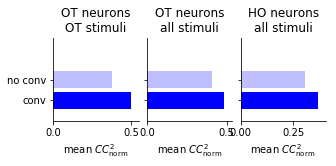

In [16]:
draw_one_stuff('MkA_Shape', 'A')

OT OT
all OT
all HO


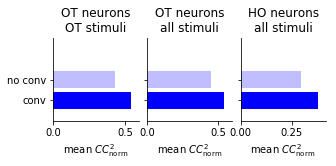

In [17]:
draw_one_stuff('MkE2_Shape', 'E2')